In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD


In [2]:
def create_model():
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])

# # from tensorflow.keras.layers import Dropout
# # from tensorflow.keras import regularizers
# # def create_model():
# #     model = Sequential([
# #         Flatten(input_shape=(28, 28)),
# #         Dense(256, activation='relu'),
# #         Dropout(0.2),  # New dropout layer
# #         Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # New regularizer
# #         Dense(10, activation='softmax')
# #     ])
    model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization

# def create_model():
#     model = Sequential([
#         # Reshape the input to be 28x28x1 (as required for Conv2D layers)
#         tf.keras.layers.Reshape(target_shape=(28, 28, 1), input_shape=(28, 28)),

#         # First Convolutional Block
#         Conv2D(32, kernel_size=(3, 3), activation='relu'),
#         BatchNormalization(),
#         MaxPooling2D(pool_size=(2, 2)),
#         Dropout(0.25),

#         # Second Convolutional Block
#         Conv2D(64, kernel_size=(3, 3), activation='relu'),
#         BatchNormalization(),
#         MaxPooling2D(pool_size=(2, 2)),
#         Dropout(0.25),

#         # Flattening the layers
#         Flatten(),

#         # Fully Connected Layer
#         Dense(128, activation='relu'),
#         Dropout(0.5),

#         # Output Layer
#         Dense(10, activation='softmax')
#     ])

#     model.compile(optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#     return model


Load and Preprocess the Dataset:

Load the MNIST dataset and split it into several partitions to simulate different clients.

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize data

# # Split training data into 'n_clients' to simulate a federated setting
# n_clients = 5
# client_data_size = len(x_train) // n_clients
# client_train_datasets = [((x_train[i*client_data_size:(i+1)*client_data_size],
#                            y_train[i*client_data_size:(i+1)*client_data_size])) for i in range(n_clients)]

# Initialize clients and train models
n_clients = 5
client_data_size = len(x_train) // n_clients
client_models = [create_model() for _ in range(n_clients)]
client_train_datasets = [
    (x_train[i*client_data_size:(i+1)*client_data_size], y_train[i*client_data_size:(i+1)*client_data_size])
    for i in range(n_clients)
]


11490434/11490434 [==============================] - 0s 0us/step


In [4]:
# Track accuracy and loss for visualization
global_history = {'accuracy': [], 'loss': []}

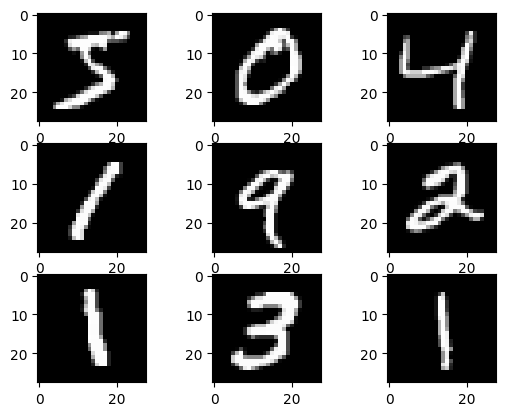

In [5]:
from matplotlib import pyplot
for i in range(9):
  pyplot.subplot(330 + 1 + i)
  pyplot.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))
pyplot.show()

Define the Model Creation Function:

This function will be used to create a new model for each client.

In [6]:
# Evaluate the initial global model before training
initial_global_model = create_model()  # A fresh model that hasn't been trained
initial_loss, initial_accuracy = initial_global_model.evaluate(x_test, y_test, verbose=0)
print(f"Initial Global model accuracy: {initial_accuracy*100:.2f}%")

Initial Global model accuracy: 7.08%


Train Models on Each Client:

Train a separate model on each client's data.

In [7]:
# client_models = [create_model() for _ in range(n_clients)]

# for client_model, client_data in zip(client_models, client_train_datasets):
#     x, y = client_data
#     client_model.fit(x, y, epochs=5)
# Train each client model and collect their histories
for client_model, client_data in zip(client_models, client_train_datasets):
    x, y = client_data
    history = client_model.fit(x, y, epochs=5, verbose=0)
    global_history['accuracy'].append(history.history['accuracy'])
    global_history['loss'].append(history.history['loss'])

In [8]:
global_history['accuracy']

[[0.690500020980835,
  0.8552500009536743,
  0.8793333172798157,
  0.8913333415985107,
  0.8987500071525574],
 [0.6827499866485596,
  0.8576666712760925,
  0.8793333172798157,
  0.8895833492279053,
  0.8976666927337646],
 [0.6708333492279053,
  0.8500000238418579,
  0.8735833168029785,
  0.8849166631698608,
  0.8931666612625122],
 [0.6738333106040955,
  0.8451666831970215,
  0.8710833191871643,
  0.8849166631698608,
  0.8917499780654907],
 [0.6932500004768372,
  0.859666645526886,
  0.8819166421890259,
  0.8933333158493042,
  0.9002500176429749]]

In [ ]:
# from google.colab import files
# from PIL import Image
# import io

# def upload_and_predict(model):
#     uploaded = files.upload()

#     # Assuming the user uploads one image file
#     for fn in uploaded.keys():
#         # Open the image
#         path = io.BytesIO(uploaded[fn])
#         img = Image.open(path).convert('L')  # convert to grayscale
#         img = img.resize((28, 28))  # resize to 28x28 pixels

#         # Preprocess the image
#         img_array = np.array(img)
#         img_array = img_array.reshape(1, 28, 28) / 255.0  # Normalize the image

#         # Predict the digit
#         prediction = model.predict(img_array)
#         predicted_digit = np.argmax(prediction)
#         print(f"Predicted Digit: {predicted_digit}")

In [ ]:
# for client_model in client_models:
#   upload_and_predict(client_model)

In [ ]:
# initial_global_model = create_model()  # A fresh model that hasn't been trained
# initial_loss, initial_accuracy = initial_global_model.evaluate(x_test, y_test, verbose=0)
# print(f"Initial Global model accuracy: {initial_accuracy*100:.2f}%")

Aggregate the Models:

This is a simple way to aggregate the models by averaging their weights.

In [9]:
# global_weights = [np.array(weights) for weights in client_models[0].get_weights()]

# for client_model in client_models[1:]:
#     for i, weights in enumerate(client_model.get_weights()):
#         global_weights[i] += np.array(weights)

# global_weights = [weights / n_clients for weights in global_weights]

# # Create a new global model
# global_model = create_model()
# global_model.set_weights(global_weights)

# Create a global model and set its weights to the average of the client models
global_model = create_model()
global_weights = [np.array(weights) for weights in client_models[0].get_weights()]
for client_model in client_models[1:]:
    for i, weights in enumerate(client_model.get_weights()):
        global_weights[i] += np.array(weights)
global_weights = [weights / n_clients for weights in global_weights]
global_model.set_weights(global_weights)


In [ ]:
# # Update each client model with the weights of the global model
# for client_model in client_models:
#     client_model.set_weights(global_model.get_weights())

# # Optionally, you can re-evaluate each client model to see the improvement
# for i, client_model in enumerate(client_models):
#     loss, accuracy = client_model.evaluate(x_test, y_test, verbose=0)
#     print(f"Client {i+1} Model Accuracy after Global Update: {accuracy:.4f}")

In [10]:
# from google.colab import files
# from PIL import Image
# import io

# def upload_and_predict(model):
#     uploaded = files.upload()

#     # Assuming the user uploads one image file
#     for fn in uploaded.keys():
#         # Open the image
#         path = io.BytesIO(uploaded[fn])
#         img = Image.open(path).convert('L')  # convert to grayscale
#         img = img.resize((28, 28))  # resize to 28x28 pixels

#         # Preprocess the image
#         img_array = np.array(img)
#         img_array = img_array.reshape(1, 28, 28) / 255.0  # Normalize the image

#         # Predict the digit
#         prediction = model.predict(img_array)
#         predicted_digit = np.argmax(prediction)
#         print(f"Predicted Digit: {predicted_digit}")

In [ ]:
# for client_model in client_models:
#   loss, accuracy = client_model.evaluate(x_test, y_test, verbose=0)
#   print(accuracy)
#   upload_and_predict(client_model)

In [ ]:
# pre_update_accuracies = []
# post_update_accuracies = []


Federated Training/Averaging

In [ ]:
# num_rounds = 5  # You can adjust this number based on your requirements
# for round in range(num_rounds):
#     print(f"Round {round + 1}/{num_rounds}")

#     # Train each client model and collect their histories
#     for client_model, client_data in zip(client_models, client_train_datasets):
#         x, y = client_data
#         history = client_model.fit(x, y, epochs=5, verbose=0)
#         global_history['accuracy'].append(history.history['accuracy'])
#         global_history['loss'].append(history.history['loss'])

#     # Aggregate the models to create a new global model
#     global_weights = [np.array(weights) for weights in client_models[0].get_weights()]
#     for client_model in client_models[1:]:
#         for i, weights in enumerate(client_model.get_weights()):
#             global_weights[i] += np.array(weights)
#     global_weights = [weights / n_clients for weights in global_weights]

#     # Update the global model with the new weights
#     global_model = create_model()
#     global_model.set_weights(global_weights)

#     # Optionally evaluate the global model at each round
#     loss, accuracy = global_model.evaluate(x_test, y_test, verbose=0)
#     print(f"Accuracy after round {round + 1}: {accuracy*100:.2f}%")

#     # Distribute the global model weights back to each client
#     for client_model in client_models:
#         client_model.set_weights(global_weights)



# num_rounds = 5  # Number of federated learning rounds
# for round in range(num_rounds):
#     print(f"Round {round + 1}/{num_rounds}")

#     # Evaluate each client model before updating with global weights
#     for i, client_model in enumerate(client_models):
#         loss, accuracy = client_model.evaluate(x_test, y_test, verbose=0)
#         pre_update_accuracies.append(accuracy)

#     # Train each client model
#     for client_model, client_data in zip(client_models, client_train_datasets):
#         x, y = client_data
#         client_model.fit(x, y, epochs=5, verbose=0)

#     # Aggregate the models to create a new global model
#     global_weights = [np.array(weights) for weights in client_models[0].get_weights()]
#     for client_model in client_models[1:]:
#         for i, weights in enumerate(client_model.get_weights()):
#             global_weights[i] += np.array(weights)
#     global_weights = [weights / n_clients for weights in global_weights]

#     # Update the global model with the new weights
#     global_model = create_model()
#     global_model.set_weights(global_weights)

#     # Distribute the global model weights back to each client
#     for client_model in client_models:
#         client_model.set_weights(global_weights)

#     # Evaluate each client model after updating with global weights
#     for i, client_model in enumerate(client_models):
#         loss, accuracy = client_model.evaluate(x_test, y_test, verbose=0)
#         post_update_accuracies.append(accuracy)

In [ ]:
# # After all rounds are completed, print out the accuracies
# print("Client Model Accuracies:")
# print("Round", *[f"Client {i+1}" for i in range(n_clients)], sep='\t')

# for round in range(num_rounds):
#     print(f"{round+1}", end='\t')
#     for i in range(n_clients):
#         pre_accuracy = pre_update_accuracies[i*num_rounds + round]
#         post_accuracy = post_update_accuracies[i*num_rounds + round]
#         print(f"{pre_accuracy:.4f} -> {post_accuracy:.4f}", end='\t')
#     print()  # Newline for the next round


In [ ]:
# import matplotlib.pyplot as plt
# # # Plot the accuracies before and after each round
# # plt.figure(figsize=(12, 6))
# # rounds = np.arange(1, num_rounds + 1)
# # for i in range(n_clients):
# #     plt.plot(rounds, pre_update_accuracies[i*num_rounds:(i+1)*num_rounds], label=f'Client {i+1} Pre-Update', marker='o')
# #     plt.plot(rounds, post_update_accuracies[i*num_rounds:(i+1)*num_rounds], label=f'Client {i+1} Post-Update', marker='x')

# # plt.xlabel('Rounds')
# # plt.ylabel('Accuracy')
# # plt.title('Client Model Accuracies Before and After Updating with Global Weights')
# # plt.legend()
# # plt.xticks(rounds)
# # plt.show()
# # Determine the number of rows needed for subplots based on the number of clients
# num_rows = n_clients // 2 + n_clients % 2
# fig, axs = plt.subplots(num_rows, 2, figsize=(14, num_rows*4))  # Adjust the figure size as needed
# axs = axs.flatten()  # Flatten the array of axes for easy indexing

# for i in range(n_clients):
#     # Extract the accuracy for the current client across all rounds
#     client_pre_update_accuracies = pre_update_accuracies[i*num_rounds:(i+1)*num_rounds]
#     client_post_update_accuracies = post_update_accuracies[i*num_rounds:(i+1)*num_rounds]

#     # Plot on the ith subplot
#     axs[i].plot(rounds, client_pre_update_accuracies, label='Pre-Update', marker='o', linestyle='-')
#     axs[i].plot(rounds, client_post_update_accuracies, label='Post-Update', marker='x', linestyle='--')

#     axs[i].set_title(f'Client {i+1} Model Accuracy')
#     axs[i].set_xlabel('Rounds')
#     axs[i].set_ylabel('Accuracy')
#     axs[i].legend()
#     axs[i].set_xticks(rounds)  # Ensure all plots have the same x-axis ticks

# # If the number of clients is odd, hide the last subplot (if unused)
# if n_clients % 2 != 0:
#     axs[-1].axis('off')

# plt.tight_layout()  # Adjust subplots to fit into the figure area.
# plt.show()


Evaluate the Global Model:

Final Global model accuracy after federated training: 70.59%


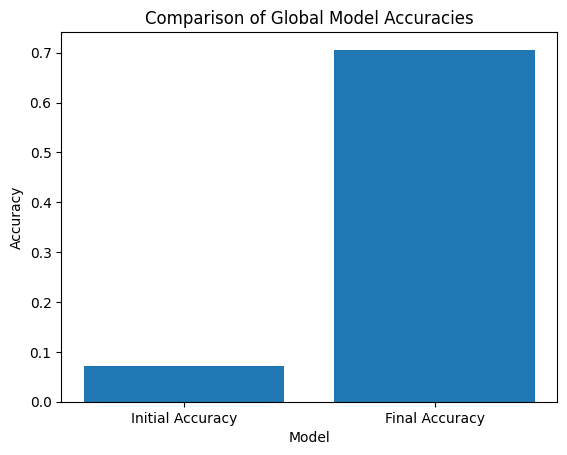

In [12]:
# loss, accuracy = global_model.evaluate(x_test, y_test)
# print(f"Global model accuracy: {accuracy*100:.2f}%")

import matplotlib.pyplot as plt


# Evaluate the final global model after federated training
final_loss, final_accuracy = global_model.evaluate(x_test, y_test, verbose=0)
print(f"Final Global model accuracy after federated training: {final_accuracy*100:.2f}%")

# Now you can plot the initial and final accuracy to show the improvement
plt.bar(['Initial Accuracy', 'Final Accuracy'], [initial_accuracy, final_accuracy])
plt.title('Comparison of Global Model Accuracies')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.show()

In [13]:
from google.colab import files
from PIL import Image
import io

def upload_and_predict(model):
    uploaded = files.upload()

    # Assuming the user uploads one image file
    for fn in uploaded.keys():
        # Open the image
        path = io.BytesIO(uploaded[fn])
        img = Image.open(path).convert('L')  # convert to grayscale
        img = img.resize((28, 28))  # resize to 28x28 pixels

        # Preprocess the image
        img_array = np.array(img)
        img_array = img_array.reshape(1, 28, 28) / 255.0  # Normalize the image

        # Predict the digit
        prediction = model.predict(img_array)
        predicted_digit = np.argmax(prediction)
        print(f"Predicted Digit: {predicted_digit}")
# from google.colab import files
# from PIL import Image
# import numpy as np
# import io

# def upload_and_predict(model):
#     uploaded = files.upload()

#     for fn in uploaded.keys():
#         # Open the image and convert to grayscale
#         path = io.BytesIO(uploaded[fn])
#         img = Image.open(path).convert('L')

#         # MNIST images are white on black, so we invert the image if it is black on white
#         # This is done by checking if the mean color is closer to black or white
#         if np.mean(img) > 127.5:
#             img = Image.fromarray(255 - np.array(img))

#         # Resize the image to 28x28 pixels
#         img = img.resize((28, 28))

#         # Convert the image to a numpy array and normalize it
#         img_array = np.array(img)
#         img_array = img_array.reshape(1, 28, 28) / 255.0

#         # Predict the digit
#         prediction = model.predict(img_array)
#         predicted_digit = np.argmax(prediction)
#         print(f"Predicted Digit: {predicted_digit}")

# from google.colab import files
# from PIL import Image, ImageOps
# import io
# import numpy as np

# def upload_and_predict(model):
#     uploaded = files.upload()

#     for fn in uploaded.keys():
#         path = io.BytesIO(uploaded[fn])
#         img = Image.open(path).convert('L')

#         # Invert image colors to match MNIST if necessary
#         if np.mean(img) > 127.5:  # If the image is light on dark background
#             img = ImageOps.invert(img)

#         # Resize to 28x28 pixels
#         img = img.resize((28, 28), Image.Resampling.LANCZOS)

#         # Convert to numpy array and normalize
#         img_array = np.array(img) / 255.0
#         img_array = img_array.reshape(1, 28, 28, 1)  # Reshape for the model

#         # Predict the digit
#         prediction = model.predict(img_array)
#         predicted_digit = np.argmax(prediction)
#         print(f"Predicted Digit: {predicted_digit}")






In [14]:
upload_and_predict(global_model)


Saving OIP.jpg to OIP (2).jpg
1/1 [==============================] - 0s 76ms/step
Predicted Digit: 5


**Core Principles of Federated Learning for Privacy and Security:**
**Local Data Stays Local:**

In real-world FL, training data remains on the local device (e.g., a hospital's server). This means sensitive health data does not leave the premises, reducing the risk of data breaches during transfer.
Code Context: In the example, each 'client' trains the model on their own data (client_model.fit(x, y, epochs=5)). In practice, this would happen on the client's local machine, not centrally.

**Aggregated Model, Not Data:**

Only the model parameters or updates (weights, gradients) are sent to the central server for aggregation, not the data itself.
Code Context: The aggregation (global_weights[i] += np.array(weights)) happens without ever accessing the individual data points.

**Reduced Risk of Data Exposure:**

Since raw data is not pooled or shared, the risk of exposing patient data is significantly reduced. This is particularly important in healthcare, where data is highly sensitive.

**Compliance with Regulations**:

FL aligns with data privacy regulations like HIPAA (in the US), GDPR (in the EU), which mandate strict handling and sharing of personal data.
Explanation: You can highlight that FL's design adheres to the principle of data minimization and privacy by design, key aspects of these regulations.

**Enhancing the Privacy and Security Aspect:**
To further emphasize the security aspect in healthcare applications, you can discuss additional measures that are typically integrated into FL systems:

**Differential Privacy:**
Techniques to ensure that the model updates shared with the server do not reveal information about individual data points.

**Secure Aggregation:**
 Cryptographic techniques to securely aggregate model updates, ensuring that no single update can be inspected independently at the server.

**Robustness to Attacks:** Implementing strategies to protect against potential attacks like model inversion or membership inference attacks.



**Communicating with Healthcare Professionals:**
When discussing with healthcare professionals, focus on:

Patient Privacy: Emphasize how FL preserves patient confidentiality by not requiring data sharing.
Regulatory Compliance: Highlight how FL's design is conducive to meeting strict healthcare data regulations.
Real-world Examples: Reference existing FL projects in healthcare that have successfully managed to leverage data without compromising privacy.

Federated Learning (FL) offers several significant benefits to organizations in the healthcare sector. Here's how it can help your organization:

1. Enhanced Data Privacy and Security

Local Data Processing: FL allows for the training of machine learning models directly on the devices or servers where the data is stored, without the need to transfer sensitive patient data.
Compliance with Regulations: This approach aligns with strict healthcare data privacy regulations like HIPAA (US) and GDPR (Europe), as it minimizes the risk of data breaches and unauthorized access.

2. Leveraging Diverse Data Sources Without Compromising Privacy

Access to Varied Data: Healthcare data is diverse and often siloed in different institutions. FL enables your organization to benefit from this diverse data (different patient demographics, diseases, treatments) without the need for direct access or sharing of the data.
Improved Model Robustness: Models trained on a wider variety of data can be more robust and generalize better, leading to improved diagnostic tools, predictive models, and patient care strategies.

3. Collaboration and Research

Collaborative Opportunities: FL facilitates collaboration with other healthcare institutions, research bodies, and pharmaceutical companies while maintaining data privacy. This can lead to more comprehensive research studies and shared insights.
Cross-Institutional Learning: It allows for the collective improvement of algorithms and healthcare models without compromising the confidentiality of each institution's data.

4. Cost-Effective and Efficient

Reduced Data Transfer Costs: Since the data remains local, the costs and resources associated with data transfer and storage are significantly reduced.
Utilization of Existing Infrastructure: FL can often be implemented using existing computational resources at each location, avoiding the need for significant infrastructure investments.

5. Personalized and Precision Medicine

Patient-Specific Insights: By learning from a wide range of patient data, FL can help in developing more personalized treatment plans and precision medicine approaches.
Real-World Data Utilization: FL enables the use of real-world, multi-center data, which is crucial for personalized healthcare.

6. Scalability and Adaptability

Scalable to New Data Sources: As new data sources become available (e.g., new hospitals or wearable health devices), they can be easily integrated into the federated network.
Adaptable Models: FL systems can continuously evolve and improve as they receive new data, ensuring that the models stay relevant and effective.

7. Ethical Use of Data

Promoting Ethical Standards: By prioritizing data privacy, FL aligns with the ethical considerations necessary in healthcare, fostering trust among patients and stakeholders.
Conclusion
For your organization, adopting Federated Learning could mean a significant step forward in utilizing advanced data analytics while upholding the highest standards of data privacy and security. It can lead to better patient outcomes, more efficient use of resources, and a stronger position in collaborative research and innovation in the healthcare sector.


1. Keeping Patient Information Safe
Privacy First: Imagine each hospital has a lockbox (their database) with patient records. With FL, instead of sending these records out to study them, we send a smart tool to each lockbox. This tool learns from the records but doesn't take any away. This means patient information stays safe and private at the hospital.

2. Learning from Many Hospitals Without Sharing Data

Better Insights: If we learn a little from many hospitals, we get a bigger picture of patient health. FL does this without ever moving the patient records around. So, we understand more about different health conditions without risking patient privacy.

3. Working Together While Keeping Secrets

Collaboration Without Risk: Different hospitals can work together to improve health treatments. They do this by sharing what they learn (not the patient data) with a central system, which combines all the learnings. It's like sharing recipes without giving away the secret ingredients.

4. No Need for Big Moves

Cost and Efficiency: Since we're not moving around huge amounts of patient data, it's cheaper and easier. Hospitals use their existing computers and systems, so there's no need for big changes or expenses.

5. Customized Healthcare

Personalized Treatments: By learning from a wide range of patients, treatments can be more tailored to individual needs. It's like having a diet plan suited just for you, based on lots of successful diets.

6. Easy to Grow and Change

Flexible and Scalable: As new hospitals or clinics join in, they can easily be part of this learning network. Also, the system gets smarter over time as it learns more, just like a doctor who becomes more experienced.

7. Doing the Right Thing

Ethical Approach: This method is a good way to use technology responsibly in healthcare. Patients and the public can trust that their sensitive health information is being handled correctly.

In Summary

For your healthcare organization, Federated Learning is like having a network of hospitals sharing lessons learned without exchanging any patient details. It's a secure, smart, and cost-effective way to make healthcare better and more personalized.

**Imagine a Cooking Contest**

Scenario: Think of Federated Learning like a cooking contest happening in different kitchens across a city. Each kitchen (like a hospital or clinic) has its own unique set of ingredients (patient data).
Learning Recipes Locally

Cooking in Each Kitchen: Each chef (a machine learning model) in their kitchen (hospital/clinic) creates a recipe (a health prediction model) using only their ingredients (local patient data). They're trying to make the best dish (the most accurate health predictions) they can, but they only use what they have in their kitchen.

Sharing the Cooking Experience, Not the Ingredients
Sharing Tips Without Giving Ingredients: After some trial and error, each chef finds some tricks that make their recipe better. They share these tips (model learnings) with a master chef (central server). Importantly, they don’t send any of their actual ingredients (patient data); they just send their cooking tips.

Creating a Master Recipe
Combining All Tips: The master chef (central server) takes all these tips and combines them to create a master recipe. This recipe now includes the wisdom from all the individual kitchens but none of their specific ingredients.

Sending Back the Improved Recipe
Improving Local Dishes: The master chef sends back this improved master recipe to each kitchen. Now, each chef updates their local recipe with these new insights. This way, every kitchen benefits from the shared knowledge without having ever exchanged their unique ingredients.

The Result
Better Dishes Everywhere: Each kitchen ends up with a better recipe than they could have made on their own, all without sharing their individual, unique ingredients. In healthcare, this means better health predictions and treatments developed without ever sharing patient data.

Summary
In Federated Learning, everyone learns more and gets better results by sharing their experience, not their data. It's a way of making sure sensitive information (like patient health records) stays private while still benefiting from shared knowledge.